In [1]:
import numpy as np
import pandas as pd
import csv
from joblib import load
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 5, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [2]:
palette_models = {  
    'PepZOO': '#AF55FF',
    'HydrAMP': '#B80018',
    # 'PepCVAEZero': '#A69FFF',
    'PepCVAE': '#0F5257',     
    # 'BasicZero': '#1d3557',
    'Basic': '#660708',         
}

In [3]:
def get_amp_data():
    models = ['basic', 'pepcvae', 'hydramp']
    data = []
    hydr_file = open('../../result/hydramp/amp_case1.csv','r')
    basic_file = open('../../result/basic/case1_result.csv','r')
    pepcvae_file = open('../../result/pepcvae/case1_result.csv','r')
    hydr_reader = csv.reader(hydr_file)
    basic_reader = csv.reader(basic_file)
    pepcvae_reader = csv.reader(pepcvae_file)
    next(hydr_reader)
    next(basic_reader)
    next(pepcvae_reader)
    prototype_amp_list = []
    hydramp_amp_list = []
    hydramp_zero_amp_list = []
    basic_amp_list = []
    basic_zero_amp_list = []

    pepcvae_amp_list = []
    pepcvae_zero_amp_list = []

    for row in hydr_reader:
        _, t = row[0].split('_')
        if t == 'original':
            prototype_amp_list.append(float(row[2]))
        if t == 'HydrampOpt':
            hydramp_amp_list.append(float(row[2]))
        if t == 'HydrampZeroOpt':
            hydramp_zero_amp_list.append(float(row[2]))
    for row in basic_reader:
        _, t = row[0].split('_')
        if t == 'BasicOpt':
            basic_amp_list.append(float(row[2]))
        if t == 'BasicZeroOpt':
            basic_zero_amp_list.append(float(row[2]))

    for row in pepcvae_reader:
        _, t = row[0].split('_')
        if t == 'PepCVAEOpt':
            pepcvae_amp_list.append(float(row[2]))
        if t == 'PepCVAEZeroOpt':
            pepcvae_zero_amp_list.append(float(row[2]))

    data.append([hydramp_zero_amp_list])
    data.append([hydramp_amp_list])
    # data.append([pepcvae_zero_amp_list, pepcvae_zero_mic_list])  
    data.append([pepcvae_amp_list])  
    # data.append([basic_zero_amp_list, basic_zero_mic_list])
    data.append([basic_amp_list])
    hydr_file.close()
    basic_file.close()
    pepcvae_file.close()  
    return prototype_amp_list, data
    

In [4]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    # ax.set_xticks([1,2,3,4])
    # ax.set_xticklabels([k,k,k,k])

In [11]:
def generate_classifier_distribution_plot(
    prototype_amp,
    optimized_amp,
):
    

    fig, (ax0a, ax1) = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(6, 2.5),
        dpi=300,
        sharey=True,
        gridspec_kw={'width_ratios': [1, 4]}
    )

    ax0a_parts = ax0a.violinplot(
        dataset=prototype_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 

    )
    
    set_axis_style(ax0a, [prototype_amp], 'AMP before')

    for parts, color in zip([ax0a_parts], ['#ffd23f']):
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)   

    for ax in [ax0a]:
        ax.set_xticks([1])
        ax.set_xticklabels(['Prototype'])
        # ax.set_xticklabels([])

    ax0a.set_ylabel('$P_{AMP}$')




    parts1 = ax1.violinplot(
        dataset=optimized_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax1, optimized_amp, 'Optimized')

    for ax in [ax1]:
        ax.spines['left'].set_visible(False)

    for parts in [parts1]:
        for pc, color in zip(parts['bodies'], palette_models.values()):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)
    
    for i, (label, ax) in enumerate(
    zip(['e'], [ax0a])
    ):
        ax.annotate(label, xy=(0.1, 1.08), xycoords='axes fraction',
          fontweight='bold', va='top', ha='right')
    
    ax1.set_xticks([1,2,3,4])
    ax1.set_xticklabels(['PepZOO', 'HydrAMP', 'PepCVAE', 'Basic'])
    ax1.annotate('Case 1 generation from prototypes', xy=(0.5, 1.15), xycoords='axes fraction', fontweight='bold', va='top', ha='right') 
    # ax1.set_xticklabels([])
    # ax2.set_xticklabels([])
    
    # fig.autofmt_xdate(rotation=45)

    return fig

In [12]:
def plot_classifier_distribution(data, prototype_amp):
    
    optimized_amp = [x[0] for x in data]
    
    fig = generate_classifier_distribution_plot(
        prototype_amp,
        optimized_amp,
    )

    return fig

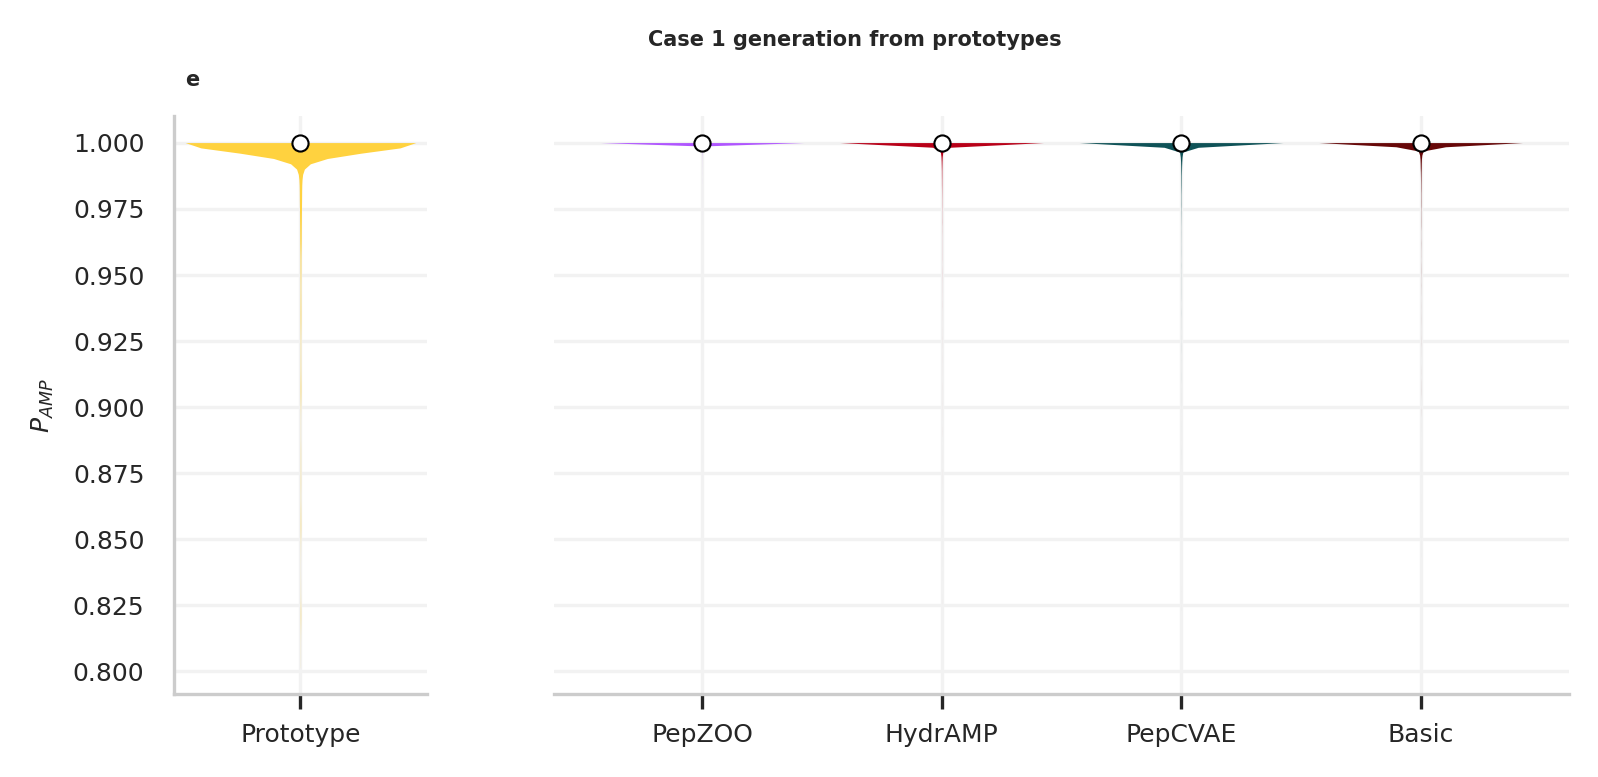

In [13]:
prototype_amp_list, data = get_amp_data()

fig = plot_classifier_distribution(data, prototype_amp_list)
fig.savefig("../figures/figure/amp_case1_amp.svg")
plt.show()

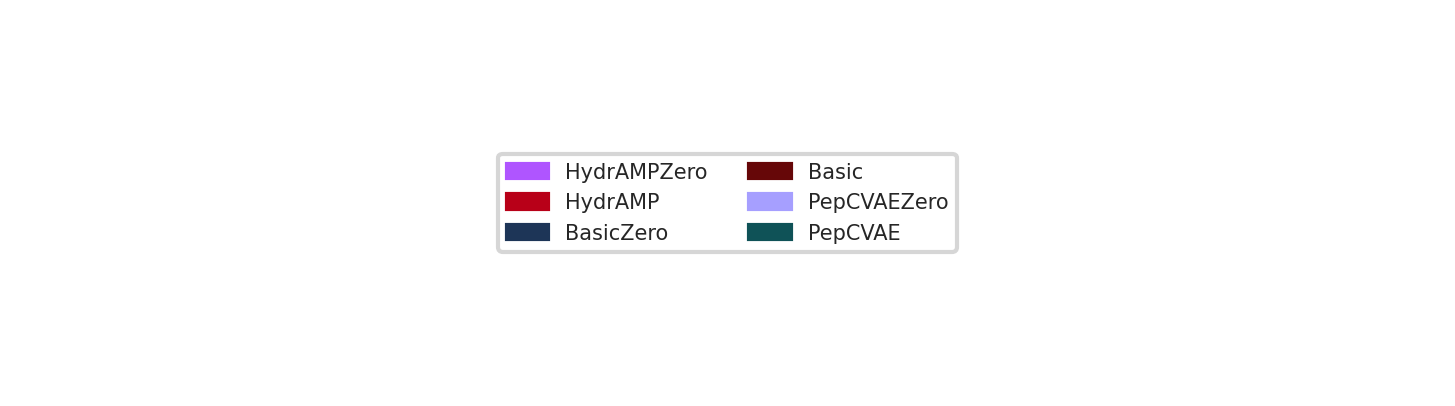

In [9]:
fig, ax1= plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 1.5),
    dpi=300,
)

patches = [mpatches.Patch(color=color, label=label) for label, color in palette_models.items()]
plt.legend(handles=patches, ncol=2,loc='center')

# fig.tight_layout()
plt.axis('off')
plt.savefig('../figures/figure/annotations.svg')
plt.show()

In [ ]:
test_data_dict = {}

for name, item in zip(
    ['positives_amp', 'positives_mic', 'negatives_amp', 'negatives_mic'],
    [pos_amp, pos_mic, neg_amp, neg_mic]):
    test_data_dict[name] = np.quantile(item, [0.25, 0.5, 0.75])
    
df = pd.DataFrame.from_dict(test_data_dict)
df.index = [25, 50, 75]
df.to_csv('SourceData_Figure3_testdata.csv')

In [27]:

def get_quantiles(data, mode='neg'):

    hydramp_1, hydramp_2, hydramp_5 = data[:3]
    pepcvae, basic, joker =  data[3:]

    prototype_amp_dict = {}
    prototype_mic_dict = {}
    analogue_amp_dict = {}
    analogue_mic_dict = {}

    for model_name, model_results in zip(
        ['HydrAMP tau=1', 'HydrAMP tau=2', 'HydrAMP tau=5', 'PepCVAE', 'Basic', 'Joker'],
        [hydramp_1, hydramp_2, hydramp_5, pepcvae, basic, joker]):

        prototype_amp, prototype_mic, analogue_amp, analogue_mic = model_results
        
        prototype_amp_dict[f'{model_name}'] = np.quantile(prototype_amp, [0.25, 0.5, 0.75])
        prototype_mic_dict[f'{model_name}'] = np.quantile(prototype_mic, [0.25, 0.5, 0.75])
        analogue_amp_dict[f'{model_name}'] = np.quantile(analogue_amp, [0.25, 0.5, 0.75])
        analogue_mic_dict[f'{model_name}'] = np.quantile(analogue_mic, [0.25, 0.5, 0.75])
        
        frames = []
        for dict_frame in [prototype_amp_dict, analogue_amp_dict, prototype_mic_dict, analogue_mic_dict]:
            df = pd.DataFrame.from_dict(dict_frame)
            df.index = [25, 50, 75]
            frames.append(df)

        df = pd.concat(frames, keys=['prototype_amp', 'analogue_amp', 'prototype_mic', 'analogue_mic'])
        
    return df
    

In [122]:
neg_df = get_quantiles(neg_data)
pos_df = get_quantiles(pos_data)

neg_df.to_csv('SourceData_Figure3ab.csv')
pos_df.to_csv('SourceData_Figure3ef.csv')

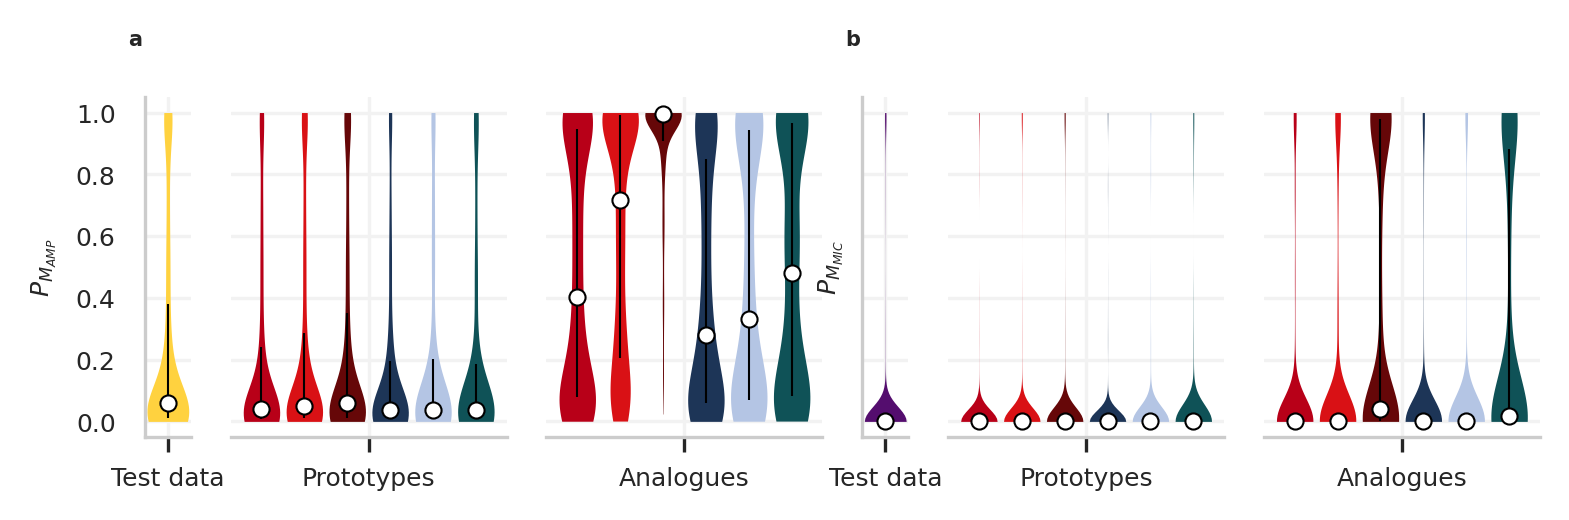

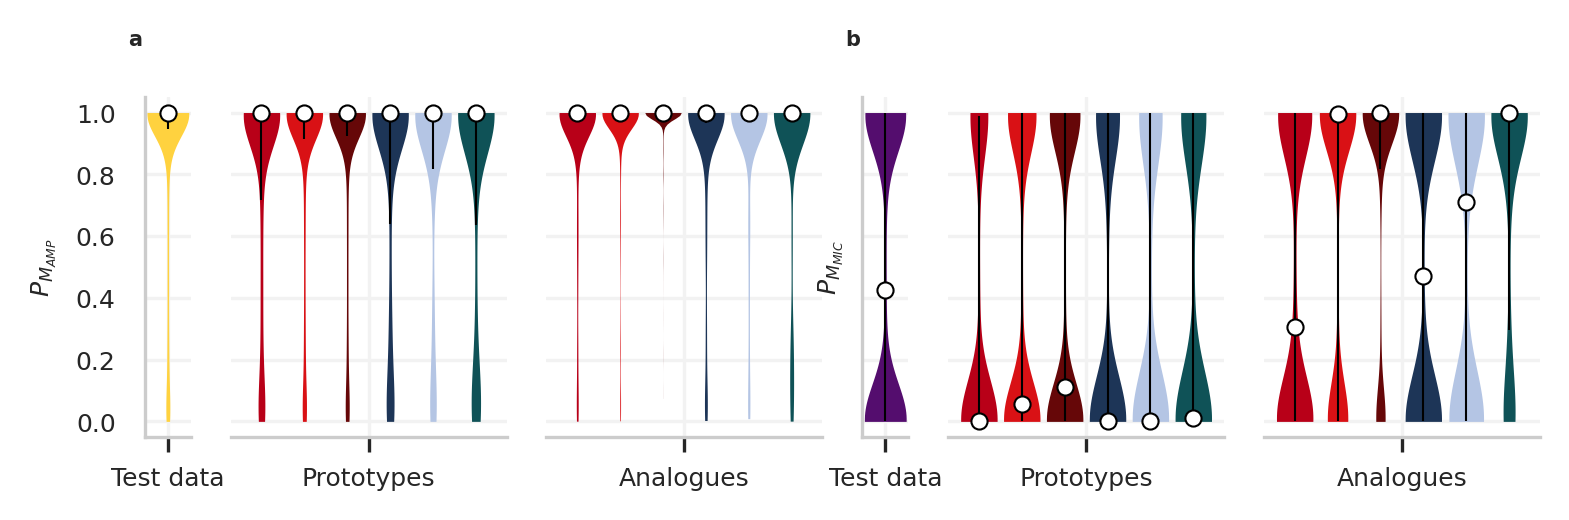

In [123]:
pos_amp, pos_mic, neg_amp, neg_mic, pos_data, neg_data = get_data(results, 'improvement')

fig = plot_classifier_distribution(neg_data, neg_amp, neg_mic)
plt.show()
fig.savefig("../../figures/NegImprovement.svg")


fig = plot_classifier_distribution(pos_data, pos_amp, pos_mic)
plt.show()
fig.savefig("../../figures/PosImprovement.svg")



In [124]:
neg_df = get_quantiles(neg_data)
pos_df = get_quantiles(pos_data)

neg_df.to_csv('SourceData_Figure3cd.csv')
pos_df.to_csv('SourceData_Figure3gh.csv')